Neural Networks with qiskit

Quantum Computing refers to the use of quantum mechanical phenomena such as *superposition* and *entanglement* to perform computation. To understand quantum phenomena, it’s important to understand qubit, the unit of quantum information, and the concepts of superposition and entanglement.

Qubit or Quantum Bit is the unit of quantum information, analogous to the ‘bit’ in classical computing. In order to differentiate between a classical bit and a qubit, Dirac notation (kit notation) is used. So, the qubits are represented as |0〉and |1〉and are often read as ‘zero state’ and ‘one state’.


The 'NeuralNetwork' represents the interface for all neural networks available in Qiskit Machine Learning. It exposes a forward and a backward pass taking the data samples and trainable weights as input. A 'NeuralNetwork' does not contain any training capabilities, these are pushed to the actual algorithms / applications. Thus, a 'NeuralNetwork' also does not store the values for trainable weights. In the following, different implementations of this interfaces are introduced.

Suppose a 'NeuralNetwork' called nn. Then, the nn.forward(input, weights) pass takes either flat inputs for the data and weights of size nn.num_inputs and nn.num_weights, respectively. NeuralNetwork supports batching of inputs and returns batches of output of the corresponding shape.

**Neurons and Weights**
A neural network is ultimately just an elaborate function that is built by composing smaller building blocks called neurons. A neuron is typically a simple, easy-to-compute, and nonlinear function that maps one or more inputs to a single real number. The single output of a neuron is typically copied and fed as input into other neurons. Graphically, we represent neurons as nodes in a graph and we draw directed edges between nodes to indicate how the output of one neuron will be used as input to other neurons. It's also important to note that each edge in our graph is often associated with a scalar-value called a weight. The idea here is that each of the inputs to a neuron will be multiplied by a different scalar before being collected and processed into a single value. The objective when training a neural network consists primarily of choosing our weights such that the network behaves in a particular way.

**Feed Forward Neural Networks**
It is also worth noting that the particular type of neural network we will concern ourselves with is called a feed-forward neural network (FFNN). This means that as data flows through our neural network, it will never return to a neuron it has already visited. Equivalently, you could say that the graph which describes our neural network is a directed acyclic graph (DAG). Furthermore, we will stipulate that neurons within the same layer of our neural network will not have edges between them.

**IO Structure of Layers**
The input to a neural network is a classical (real-valued) vector. Each component of the input vector is multiplied by a different weight and fed into a layer of neurons according to the graph structure of the network. After each neuron in the layer has been evaluated, the results are collected into a new vector where the i'th component records the output of the i'th neuron. This new vector can then be treated as an input for a new layer, and so on. We will use the standard term hidden layer to describe all but the first and last layers of our network.

**So How Does Quantum Enter the Picture? **
To create a quantum-classical neural network, one can implement a hidden layer for our neural network using a parameterized quantum circuit. By "parameterized quantum circuit", we mean a quantum circuit where the rotation angles for each gate are specified by the components of a classical input vector. The outputs from our neural network's previous layer will be collected and used as the inputs for our parameterized circuit. The measurement statistics of our quantum circuit can then be collected and used as inputs for the following layer. 



In [1]:
!pip install qiskit

     |████████████████████████████████| 6.5 MB 6.0 MB/s 
     |████████████████████████████████| 18.0 MB 232 kB/s 
     |████████████████████████████████| 240 kB 9.9 MB/s 
     |████████████████████████████████| 200 kB 62.8 MB/s 
     |████████████████████████████████| 54 kB 3.0 MB/s 
     |████████████████████████████████| 111 kB 5.6 MB/s 
     |████████████████████████████████| 1.6 MB 37.8 MB/s 
     |████████████████████████████████| 49 kB 4.2 MB/s 
     |████████████████████████████████| 49 kB 6.8 MB/s 
     |████████████████████████████████| 943 kB 35.8 MB/s 
     |████████████████████████████████| 38.1 MB 2.1 MB/s 
     |████████████████████████████████| 37.5 MB 1.1 MB/s 
     |████████████████████████████████| 3.6 MB 53.6 MB/s 
     |████████████████████████████████| 113 kB 56.1 MB/s 
  Created wheel for qiskit: filename=qiskit-0.36.0-py3-none-any.whl size=11861 sha256=641dcf5cf50385c2494bc6f88a9125b83bb69fe181602656ef81988418bb824f
  Stored in directory: /root/.cache/pip/wheels

In [2]:
import numpy as np

from qiskit import Aer, QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.opflow import StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient
from qiskit.utils import QuantumInstance

In [3]:
# set method to calculcate expected values
expval = AerPauliExpectation()

# define gradient method
gradient = Gradient()

# define quantum instances (statevector and sample based)
qi_sv = QuantumInstance(Aer.get_backend('statevector_simulator'))

# we set shots to 10 as this will determine the number of samples later on.
qi_qasm = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=10)

In [4]:
!pip install qiskit_machine_learning
from qiskit_machine_learning.neural_networks import OpflowQNN

     |████████████████████████████████| 118 kB 7.4 MB/s 


In [5]:
# construct parametrized circuit
params1 = [Parameter('input1'), Parameter('weight1')]
qc1 = QuantumCircuit(1)
qc1.h(0)
qc1.ry(params1[0], 0)
qc1.rx(params1[1], 0)
qc_sfn1 = StateFn(qc1)

# construct cost operator
H1 = StateFn(PauliSumOp.from_list([('Z', 1.0), ('X', 1.0)]))

# combine operator and circuit to objective function
op1 = ~H1 @ qc_sfn1
print(op1)

ComposedOp([
  OperatorMeasurement(1.0 * Z
  + 1.0 * X),
  CircuitStateFn(
     ┌───┐┌────────────┐┌─────────────┐
  q: ┤ H ├┤ Ry(input1) ├┤ Rx(weight1) ├
     └───┘└────────────┘└─────────────┘
  )
])


In [6]:
# construct OpflowQNN with the operator, the input parameters, the weight parameters,
# the expected value, gradient, and quantum instance.
qnn1 = OpflowQNN(op1, [params1[0]], [params1[1]], expval, gradient, qi_sv)

In [7]:
# define (random) input and weights
input1 = np.random.rand(qnn1.num_inputs)
weights1 = np.random.rand(qnn1.num_weights)

In [8]:
# QNN forward pass
qnn1.forward(input1, weights1)

array([[0.38104244]])

In [9]:
# QNN batched forward pass
qnn1.forward([input1, input1], weights1)

array([[0.38104244],
       [0.38104244]])

In [10]:
# QNN backward pass
qnn1.backward(input1, weights1)

(None, array([[[0.41821187]]]))

In [11]:
# QNN batched backward pass
qnn1.backward([input1, input1], weights1)

(None, array([[[0.41821187]],
 
        [[0.41821187]]]))

In [12]:
op2 = ListOp([op1, op1])
qnn2 = OpflowQNN(op2, [params1[0]], [params1[1]], expval, gradient, qi_sv)

In [13]:
# QNN forward pass
qnn2.forward(input1, weights1)

array([[0.38104244, 0.38104244]])

In [14]:
# QNN backward pass
qnn2.backward(input1, weights1)

(None, array([[[0.41821187],
         [0.41821187]]]))

In [15]:
from qiskit_machine_learning.neural_networks import TwoLayerQNN

In [16]:
# specify the number of qubits
num_qubits = 3

     |████████████████████████████████| 162 kB 7.5 MB/s 
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136835 sha256=b16f08f71eaabef5c83c080e20e72aac2a325a1af049a364e8eb9d4b91082001
  Stored in directory: /root/.cache/pip/wheels/f1/8a/f5/33ee79d4473eb201b519fa40f989b842e373237395a3421f52
Successfully built pylatexenc


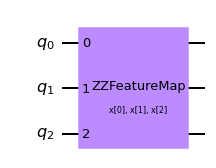

In [17]:
!pip install pylatexenc
# specify the feature map
fm = ZZFeatureMap(num_qubits, reps=2)
fm.draw(output='mpl')

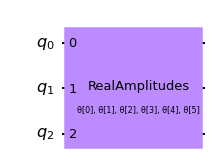

In [18]:
# specify the ansatz
ansatz = RealAmplitudes(num_qubits, reps=1)
ansatz.draw(output='mpl')

In [19]:
# specify the observable
observable = PauliSumOp.from_list([('Z'*num_qubits, 1)])
print(observable)

1.0 * ZZZ


In [20]:
# define two layer QNN
qnn3 = TwoLayerQNN(num_qubits,
                   feature_map=fm,
                   ansatz=ansatz,
                   observable=observable, quantum_instance=qi_sv)

In [21]:
# define (random) input and weights
input3 = np.random.rand(qnn3.num_inputs)
weights3 = np.random.rand(qnn3.num_weights)

In [22]:
# QNN forward pass
qnn3.forward(input3, weights3)

array([[-0.55159686]])

In [23]:
# QNN backward pass
qnn3.backward(input3, weights3)

(None, array([[[-0.23867221,  0.2161849 , -0.2827045 , -0.13140857,
          -0.23234967,  0.30634663]]]))

Classification with qiskit

In [24]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit  import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

qi = QuantumInstance(Aer.get_backend('statevector_simulator'))

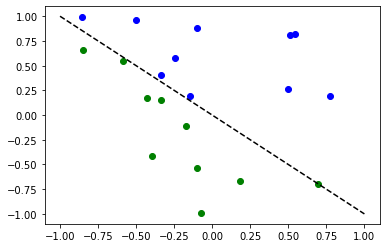

In [25]:
num_inputs = 2
num_samples = 20
X = 2*np.random.rand(num_samples, num_inputs) - 1
y01 = 1*(np.sum(X, axis=1) >= 0)  # in { 0,  1}
y = 2*y01-1                       # in {-1, +1}

X_ = Tensor(X)
y01_ = Tensor(y01).reshape(len(y)).long()
y_ = Tensor(y).reshape(len(y), 1)

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

In [26]:
# set up QNN
qnn1 = TwoLayerQNN(num_qubits=num_inputs, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn1.num_weights) - 1)
model1 = TorchConnector(qnn1, initial_weights=initial_weights)

In [27]:
# test with a single input
model1(X_[0, :])

tensor([-0.5742], grad_fn=<_TorchNNFunctionBackward>)

In [28]:
# define optimizer and loss
optimizer = LBFGS(model1.parameters())
f_loss = MSELoss(reduction='sum')

# start training
model1.train()   # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad()          # initialize gradient
    loss = f_loss(model1(X_), y_)  # evaluate loss function
    loss.backward()                # backward pass
    print(loss.item())             # print loss
    return loss

# run optimizer
optimizer.step(closure)

20.45301055908203
19.203458786010742
18.799657821655273
18.49107551574707
21.7468204498291
19.01334571838379
19.85961151123047
19.52369499206543
18.609872817993164
19.847822189331055
17.922250747680664
17.76791000366211
16.95028305053711
16.636032104492188
16.582395553588867
16.652917861938477
16.564146041870117
16.562623977661133
16.561410903930664
16.5614070892334


tensor(20.4530, grad_fn=<MseLossBackward0>)

Accuracy: 0.7


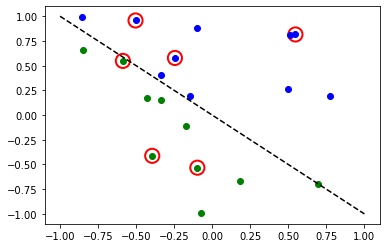

In [29]:
# evaluate model and compute accuracy
# The red circles indicate wrongly classified data points.
y_predict = []
for x, y_target in zip(X, y):
    output = model1(Tensor(x))
    y_predict += [np.sign(output.detach().numpy())[0]]

print('Accuracy:', sum(y_predict == y)/len(y))

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

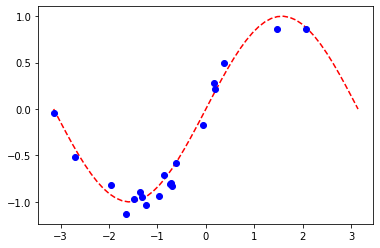

In [30]:
num_samples = 20
eps = 0.2
lb, ub = -np.pi, np.pi
f = lambda x: np.sin(x)

X = (ub - lb)*np.random.rand(num_samples, 1) + lb
y = f(X) + eps*(2*np.random.rand(num_samples, 1)-1)
plt.plot(np.linspace(lb, ub), f(np.linspace(lb, ub)), 'r--')
plt.plot(X, y, 'bo')
plt.show()

In [31]:
# construct simple feature map
param_x = Parameter('x')
feature_map = QuantumCircuit(1, name='fm')
feature_map.ry(param_x, 0)

# construct simple feature map
param_y = Parameter('y')
ansatz = QuantumCircuit(1, name='vf')
ansatz.ry(param_y, 0)

# construct QNN
qnn3 = TwoLayerQNN(1, feature_map, ansatz, quantum_instance=qi)
print(qnn3.operator)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn3.num_weights) - 1)
model3 = TorchConnector(qnn3, initial_weights)

ComposedOp([
  OperatorMeasurement(1.0 * Z),
  CircuitStateFn(
     ┌───────┐┌───────┐
  q: ┤ fm(x) ├┤ vf(y) ├
     └───────┘└───────┘
  )
])


In [32]:
# define optimizer and loss function
optimizer = LBFGS(model3.parameters())
f_loss = MSELoss(reduction='sum')

# start training
model3.train()   # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad(set_to_none=True)        # initialize gradient
    loss = f_loss(model3(Tensor(X)), Tensor(y))  # compute batch loss
    loss.backward()                              # backward pass
    print(loss.item())                           # print loss
    return loss

# run optimizer
optimizer.step(closure)

24.182039260864258
2.944024085998535
0.52800053358078
0.21038806438446045
0.20162972807884216
0.20156081020832062
0.20156076550483704


tensor(24.1820, grad_fn=<MseLossBackward0>)

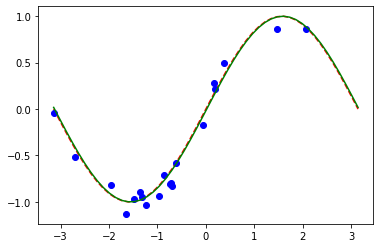

In [33]:
# plot target function
plt.plot(np.linspace(lb, ub), f(np.linspace(lb, ub)), 'r--')

# plot data
plt.plot(X, y, 'bo')

# plot fitted line
y_ = []
for x in np.linspace(lb, ub):
    output = model3(Tensor([x]))
    y_ += [output.detach().numpy()[0]]
plt.plot(np.linspace(lb, ub), y_, 'g-')
plt.show()